In [ ]:
# imports & config
import os
import random
from pathlib import Path
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image

from sklearn.preprocessing import label_binarize
import timm  
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_curve, auc)
import itertools

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Directories 
ROOT = "C:/Users/MSC055/Desktop/Sabrina/CSE754/Gallbladder DIsease/Gallbladder DIsease"  
SAVE_DIR = "C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl"
os.makedirs(SAVE_DIR, exist_ok=True)

#  hyperparams 
IMAGE_SIZE = 224
SIMCLR_EPOCHS = 50      
SIMCLR_BS = 64
SIMCLR_LR = 1e-3
PROJ_DIM = 128
TEMPERATURE = 0.5

FINETUNE_EPOCHS = 50
FINETUNE_BS = 32
FINETUNE_LR = 5e-5



c:\Users\MSC055\.conda\envs\pytorch2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [2]:
import os

data_dir = "C:/Users/MSC055/Desktop/Sabrina/CSE754/Gallbladder DIsease/Gallbladder DIsease"
classes = os.listdir(data_dir)
for cls in classes:
    print(f"Class: {cls}, Number of Images: {len(os.listdir(os.path.join(data_dir, cls)))}")

Class: 1Gallstones, Number of Images: 1326
Class: 2Abdomen and retroperitoneum, Number of Images: 1170
Class: 3cholecystitis, Number of Images: 1146
Class: 4Membranous and gangrenous cholecystitis, Number of Images: 1224
Class: 5Perforation, Number of Images: 1062
Class: 6Polyps and cholesterol crystals, Number of Images: 1020
Class: 7Adenomyomatosis, Number of Images: 1164
Class: 8Carcinoma, Number of Images: 1590
Class: 9Various causes of gallbladder wall thickening, Number of Images: 990


In [ ]:
# build file lists and do stratified 80/10/10 split
root = Path(ROOT)
assert root.exists(), f"{ROOT} not found"

image_paths = []
image_labels = []
class_names = sorted([d.name for d in root.iterdir() if d.is_dir()])
class_to_idx = {c:i for i,c in enumerate(class_names)}

for cls in class_names:
    folder = root / cls
    for p in folder.glob("*"):
        if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]:
            image_paths.append(str(p))
            image_labels.append(class_to_idx[cls])

print("Detected classes:", class_names)
print("Total images:", len(image_paths))
print("Per-class counts (original):", dict(Counter(image_labels)))

# Stratified 80% / 10% / 10%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, image_labels, test_size=0.20, stratify=image_labels, random_state=SEED
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=SEED
)

print("Split sizes -> train:", len(train_paths), "val:", len(val_paths), "test:", len(test_paths))

# Print per-class distribution for each split
idx_to_class = {v:k for k,v in class_to_idx.items()}

def print_class_counts(labels, name):
    counts = Counter(labels)
    print(f"\n{name} set class distribution:")
    for cls_idx in sorted(counts.keys()):
        print(f"  {idx_to_class[cls_idx]} ({cls_idx}): {counts[cls_idx]}")
    print("Total:", sum(counts.values()))

print_class_counts(train_labels, "Train")
print_class_counts(val_labels, "Val")
print_class_counts(test_labels, "Test")


Detected classes: ['1Gallstones', '2Abdomen and retroperitoneum', '3cholecystitis', '4Membranous and gangrenous cholecystitis', '5Perforation', '6Polyps and cholesterol crystals', '7Adenomyomatosis', '8Carcinoma', '9Various causes of gallbladder wall thickening']
Total images: 10692
Per-class counts (original): {0: 1326, 1: 1170, 2: 1146, 3: 1224, 4: 1062, 5: 1020, 6: 1164, 7: 1590, 8: 990}
Split sizes -> train: 8553 val: 1069 test: 1070

Train set class distribution:
  1Gallstones (0): 1061
  2Abdomen and retroperitoneum (1): 936
  3cholecystitis (2): 917
  4Membranous and gangrenous cholecystitis (3): 979
  5Perforation (4): 849
  6Polyps and cholesterol crystals (5): 816
  7Adenomyomatosis (6): 931
  8Carcinoma (7): 1272
  9Various causes of gallbladder wall thickening (8): 792
Total: 8553

Val set class distribution:
  1Gallstones (0): 132
  2Abdomen and retroperitoneum (1): 117
  3cholecystitis (2): 115
  4Membranous and gangrenous cholecystitis (3): 122
  5Perforation (4): 107
  

In [ ]:
# transforms and datasets

# SimCLR augmentations (two views)
simclr_transforms = T.Compose([
    T.RandomResizedCrop(IMAGE_SIZE, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply([T.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=int(0.1*IMAGE_SIZE)//2*2+1, sigma=(0.1, 2.0)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# fine-tune transforms
train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
eval_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class SimCLRDataset(Dataset):
    """Returns two augmented views for SimCLR pretraining."""
    def __init__(self, paths, transform):
        self.paths = list(paths)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2

class ImageDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = list(paths)
        self.labels = list(labels)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# loaders 
simclr_dataset = SimCLRDataset(train_paths, simclr_transforms)
simclr_loader = DataLoader(simclr_dataset, batch_size=SIMCLR_BS, shuffle=True, drop_last=True)

ft_train_dataset = ImageDataset(train_paths, train_labels, train_transform)
ft_val_dataset   = ImageDataset(val_paths, val_labels, eval_transform)
ft_test_dataset  = ImageDataset(test_paths, test_labels, eval_transform)

train_loader = DataLoader(ft_train_dataset, batch_size=FINETUNE_BS, shuffle=True)
val_loader   = DataLoader(ft_val_dataset,   batch_size=FINETUNE_BS, shuffle=False)
test_loader  = DataLoader(ft_test_dataset,  batch_size=FINETUNE_BS, shuffle=False)

print("SimCLR dataset size:", len(simclr_dataset), "batches:", len(simclr_loader))
print("Fine-tune train sizes:", len(ft_train_dataset), "\nFine-tune val sizes:", len(ft_val_dataset), "\nFine-tune test sizes:", len(ft_test_dataset))


SimCLR dataset size: 8553 batches: 133
Fine-tune train sizes: 8553 
Fine-tune val sizes: 1069 
Fine-tune test sizes: 1070


In [ ]:
# Encoder (EfficientNet-B0) + SimCLR model + NT-Xent loss

class EfficientNetB0Encoder(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        # timm model: use forward_features to get feature map (B, C, H, W)
        self.model = timm.create_model("efficientnet_b0", pretrained=pretrained, num_classes=0, global_pool="")
        
        self.out_dim = getattr(self.model, "num_features", None)
        if self.out_dim is None:
            
            raise RuntimeError("Can't determine efficientnet out_dim -- ensure timm supports num_features for model.")
        self.pool = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        # forward_features returns [B, C, H, W]
        feat_map = self.model.forward_features(x)
        pooled = self.pool(feat_map)  # [B, C, 1, 1]
        vec = torch.flatten(pooled, 1)
        return vec

class SimCLR_EfficientNet(nn.Module):
    def __init__(self, encoder, proj_dim=128, use_batchnorm_projector=True):
        super().__init__()
        self.encoder = encoder
        feat_dim = self.encoder.out_dim

        
        if use_batchnorm_projector:
            self.projector = nn.Sequential(
                nn.Linear(feat_dim, feat_dim),
                nn.BatchNorm1d(feat_dim),       
                nn.ReLU(inplace=True),
                nn.Linear(feat_dim, proj_dim),
            )
        else:
            self.projector = nn.Sequential(
                nn.Linear(feat_dim, feat_dim),
                nn.ReLU(inplace=True),
                nn.Linear(feat_dim, proj_dim),
            )

    def forward(self, x):
        h = self.encoder(x)       # representation
        z = self.projector(h)     # projection
        z = F.normalize(z, dim=1)
        return h, z

# Vectorized, numerically-stable NT-Xent
def nt_xent_loss(z_i, z_j, temperature=0.5, eps=1e-8):
    """
    z_i, z_j: normalized projections (B, D)
    returns scalar loss
    Vectorized implementation using cosine similarity (matmul)
    """
    batch_size = z_i.shape[0]
    z = torch.cat([z_i, z_j], dim=0)   # 2B x D

    # cosine similarity via dot product because z are normalized
    sim = torch.matmul(z, z.T)      # 2B x 2B
    sim = sim / temperature

    # mask self-similarities
    diag_mask = torch.eye(2 * batch_size, device=sim.device).bool()
    sim_exp = torch.exp(sim) * (~diag_mask).float()  # zero out diagonal before exp

    # denominator: sum over all except self
    denom = sim_exp.sum(dim=1, keepdim=False) + eps  # (2B,)

    # positive similarities: pairs (i, i+B) and (i+B, i)
    pos = torch.exp((z_i * z_j).sum(dim=-1) / temperature)  # (B,)
    pos = torch.cat([pos, pos], dim=0)  # (2B,)

    loss = -torch.log(pos / denom)
    return loss.mean()

# build model
base_enc = EfficientNetB0Encoder(pretrained=False)
simclr = SimCLR_EfficientNet(base_enc, proj_dim=PROJ_DIM, use_batchnorm_projector=False).to(device)
print("SimCLR model ready. Encoder out_dim:", base_enc.out_dim)


SimCLR model ready. Encoder out_dim: 1280


In [ ]:
# SimCLR pretraining loop
optimizer_simclr = torch.optim.AdamW(simclr.parameters(), lr=SIMCLR_LR, weight_decay=1e-4)
simclr_losses = []

simclr_weights_final_path = os.path.join(SAVE_DIR, "simclr_pretrain_weights.pth")

for epoch in range(1, SIMCLR_EPOCHS+1):
    simclr.train()
    running_loss = 0.0
    iters = 0
    pbar = tqdm(simclr_loader, desc=f"SimCLR Epoch {epoch}/{SIMCLR_EPOCHS}")
    for x1, x2 in pbar:
        x1 = x1.to(device); x2 = x2.to(device)
        optimizer_simclr.zero_grad()
        _, z1 = simclr(x1)
        _, z2 = simclr(x2)
        loss = nt_xent_loss(z1, z2, temperature=TEMPERATURE)
        loss.backward()
        optimizer_simclr.step()

        running_loss += loss.item()
        iters += 1
        pbar.set_postfix(loss=running_loss/iters)

    epoch_loss = running_loss / max(1, iters)
    simclr_losses.append(epoch_loss)
    print(f"SimCLR Epoch {epoch} completed. SimCLR Contrastive Loss: {epoch_loss:.6f}")

    # save final overall weights 
    torch.save({
        'epoch': SIMCLR_EPOCHS,
        'simclr_state_dict': simclr.state_dict(),
        'optimizer': optimizer_simclr.state_dict()
    }, simclr_weights_final_path)
print("SimCLR final weights saved to:", simclr_weights_final_path)



SimCLR Epoch 1/50: 100%|██████████| 133/133 [03:08<00:00,  1.42s/it, loss=4.55]


SimCLR Epoch 1 completed. SimCLR Contrastive Loss: 4.548013


SimCLR Epoch 2/50: 100%|██████████| 133/133 [03:06<00:00,  1.40s/it, loss=4.15]


SimCLR Epoch 2 completed. SimCLR Contrastive Loss: 4.152744


SimCLR Epoch 3/50: 100%|██████████| 133/133 [03:06<00:00,  1.40s/it, loss=3.99]


SimCLR Epoch 3 completed. SimCLR Contrastive Loss: 3.990575


SimCLR Epoch 4/50: 100%|██████████| 133/133 [03:05<00:00,  1.40s/it, loss=3.8] 


SimCLR Epoch 4 completed. SimCLR Contrastive Loss: 3.800540


SimCLR Epoch 5/50: 100%|██████████| 133/133 [03:07<00:00,  1.41s/it, loss=3.73]


SimCLR Epoch 5 completed. SimCLR Contrastive Loss: 3.730404


SimCLR Epoch 6/50: 100%|██████████| 133/133 [03:06<00:00,  1.40s/it, loss=3.65]


SimCLR Epoch 6 completed. SimCLR Contrastive Loss: 3.650254


SimCLR Epoch 7/50: 100%|██████████| 133/133 [03:06<00:00,  1.40s/it, loss=3.58]


SimCLR Epoch 7 completed. SimCLR Contrastive Loss: 3.583341


SimCLR Epoch 8/50: 100%|██████████| 133/133 [03:07<00:00,  1.41s/it, loss=3.53]


SimCLR Epoch 8 completed. SimCLR Contrastive Loss: 3.529215


SimCLR Epoch 9/50: 100%|██████████| 133/133 [03:06<00:00,  1.40s/it, loss=3.51]


SimCLR Epoch 9 completed. SimCLR Contrastive Loss: 3.505300


SimCLR Epoch 10/50: 100%|██████████| 133/133 [03:06<00:00,  1.40s/it, loss=3.47]


SimCLR Epoch 10 completed. SimCLR Contrastive Loss: 3.470361


SimCLR Epoch 11/50: 100%|██████████| 133/133 [03:06<00:00,  1.40s/it, loss=3.44]


SimCLR Epoch 11 completed. SimCLR Contrastive Loss: 3.439310


SimCLR Epoch 12/50: 100%|██████████| 133/133 [03:04<00:00,  1.39s/it, loss=3.41]


SimCLR Epoch 12 completed. SimCLR Contrastive Loss: 3.409261


SimCLR Epoch 13/50: 100%|██████████| 133/133 [03:04<00:00,  1.39s/it, loss=3.38]


SimCLR Epoch 13 completed. SimCLR Contrastive Loss: 3.384058


SimCLR Epoch 14/50: 100%|██████████| 133/133 [03:04<00:00,  1.39s/it, loss=3.36]


SimCLR Epoch 14 completed. SimCLR Contrastive Loss: 3.357066


SimCLR Epoch 15/50: 100%|██████████| 133/133 [03:04<00:00,  1.39s/it, loss=3.34]


SimCLR Epoch 15 completed. SimCLR Contrastive Loss: 3.341440


SimCLR Epoch 16/50: 100%|██████████| 133/133 [03:05<00:00,  1.39s/it, loss=3.33]


SimCLR Epoch 16 completed. SimCLR Contrastive Loss: 3.325290


SimCLR Epoch 17/50: 100%|██████████| 133/133 [03:04<00:00,  1.39s/it, loss=3.31]


SimCLR Epoch 17 completed. SimCLR Contrastive Loss: 3.305339


SimCLR Epoch 18/50: 100%|██████████| 133/133 [03:05<00:00,  1.39s/it, loss=3.3]


SimCLR Epoch 18 completed. SimCLR Contrastive Loss: 3.299936


SimCLR Epoch 19/50: 100%|██████████| 133/133 [03:04<00:00,  1.39s/it, loss=3.28]


SimCLR Epoch 19 completed. SimCLR Contrastive Loss: 3.276141


SimCLR Epoch 20/50: 100%|██████████| 133/133 [03:03<00:00,  1.38s/it, loss=3.26]


SimCLR Epoch 20 completed. SimCLR Contrastive Loss: 3.263147


SimCLR Epoch 21/50: 100%|██████████| 133/133 [03:06<00:00,  1.40s/it, loss=3.26]


SimCLR Epoch 21 completed. SimCLR Contrastive Loss: 3.255847


SimCLR Epoch 22/50: 100%|██████████| 133/133 [03:05<00:00,  1.40s/it, loss=3.24]


SimCLR Epoch 22 completed. SimCLR Contrastive Loss: 3.243693


SimCLR Epoch 23/50: 100%|██████████| 133/133 [03:05<00:00,  1.40s/it, loss=3.24]


SimCLR Epoch 23 completed. SimCLR Contrastive Loss: 3.239541


SimCLR Epoch 24/50: 100%|██████████| 133/133 [03:07<00:00,  1.41s/it, loss=3.22]


SimCLR Epoch 24 completed. SimCLR Contrastive Loss: 3.224261


SimCLR Epoch 25/50: 100%|██████████| 133/133 [03:06<00:00,  1.41s/it, loss=3.22]


SimCLR Epoch 25 completed. SimCLR Contrastive Loss: 3.218187


SimCLR Epoch 26/50: 100%|██████████| 133/133 [03:06<00:00,  1.40s/it, loss=3.2] 


SimCLR Epoch 26 completed. SimCLR Contrastive Loss: 3.203245


SimCLR Epoch 27/50: 100%|██████████| 133/133 [03:06<00:00,  1.40s/it, loss=3.19]


SimCLR Epoch 27 completed. SimCLR Contrastive Loss: 3.194945


SimCLR Epoch 28/50: 100%|██████████| 133/133 [03:05<00:00,  1.40s/it, loss=3.2]


SimCLR Epoch 28 completed. SimCLR Contrastive Loss: 3.198943


SimCLR Epoch 29/50: 100%|██████████| 133/133 [03:07<00:00,  1.41s/it, loss=3.18]


SimCLR Epoch 29 completed. SimCLR Contrastive Loss: 3.184276


SimCLR Epoch 30/50: 100%|██████████| 133/133 [03:07<00:00,  1.41s/it, loss=3.18]


SimCLR Epoch 30 completed. SimCLR Contrastive Loss: 3.179649


SimCLR Epoch 31/50: 100%|██████████| 133/133 [03:04<00:00,  1.39s/it, loss=3.17]


SimCLR Epoch 31 completed. SimCLR Contrastive Loss: 3.172838


SimCLR Epoch 32/50: 100%|██████████| 133/133 [03:04<00:00,  1.39s/it, loss=3.16]


SimCLR Epoch 32 completed. SimCLR Contrastive Loss: 3.161131


SimCLR Epoch 33/50: 100%|██████████| 133/133 [03:04<00:00,  1.39s/it, loss=3.16]


SimCLR Epoch 33 completed. SimCLR Contrastive Loss: 3.159690


SimCLR Epoch 34/50: 100%|██████████| 133/133 [03:05<00:00,  1.40s/it, loss=3.15]


SimCLR Epoch 34 completed. SimCLR Contrastive Loss: 3.154533


SimCLR Epoch 35/50: 100%|██████████| 133/133 [03:05<00:00,  1.40s/it, loss=3.14]


SimCLR Epoch 35 completed. SimCLR Contrastive Loss: 3.142476


SimCLR Epoch 36/50: 100%|██████████| 133/133 [03:05<00:00,  1.40s/it, loss=3.14]


SimCLR Epoch 36 completed. SimCLR Contrastive Loss: 3.144734


SimCLR Epoch 37/50: 100%|██████████| 133/133 [03:06<00:00,  1.40s/it, loss=3.14]


SimCLR Epoch 37 completed. SimCLR Contrastive Loss: 3.141747


SimCLR Epoch 38/50: 100%|██████████| 133/133 [03:05<00:00,  1.39s/it, loss=3.13]


SimCLR Epoch 38 completed. SimCLR Contrastive Loss: 3.130834


SimCLR Epoch 39/50: 100%|██████████| 133/133 [03:05<00:00,  1.40s/it, loss=3.13]


SimCLR Epoch 39 completed. SimCLR Contrastive Loss: 3.132563


SimCLR Epoch 40/50: 100%|██████████| 133/133 [03:06<00:00,  1.40s/it, loss=3.12]


SimCLR Epoch 40 completed. SimCLR Contrastive Loss: 3.123783


SimCLR Epoch 41/50: 100%|██████████| 133/133 [03:07<00:00,  1.41s/it, loss=3.12]


SimCLR Epoch 41 completed. SimCLR Contrastive Loss: 3.119712


SimCLR Epoch 42/50: 100%|██████████| 133/133 [03:06<00:00,  1.41s/it, loss=3.12]


SimCLR Epoch 42 completed. SimCLR Contrastive Loss: 3.118198


SimCLR Epoch 43/50: 100%|██████████| 133/133 [03:06<00:00,  1.41s/it, loss=3.11]


SimCLR Epoch 43 completed. SimCLR Contrastive Loss: 3.113642


SimCLR Epoch 44/50: 100%|██████████| 133/133 [03:06<00:00,  1.40s/it, loss=3.11]


SimCLR Epoch 44 completed. SimCLR Contrastive Loss: 3.107677


SimCLR Epoch 45/50: 100%|██████████| 133/133 [03:06<00:00,  1.40s/it, loss=3.11]


SimCLR Epoch 45 completed. SimCLR Contrastive Loss: 3.106414


SimCLR Epoch 46/50: 100%|██████████| 133/133 [03:04<00:00,  1.38s/it, loss=3.1]


SimCLR Epoch 46 completed. SimCLR Contrastive Loss: 3.103289


SimCLR Epoch 47/50: 100%|██████████| 133/133 [03:04<00:00,  1.39s/it, loss=3.1]


SimCLR Epoch 47 completed. SimCLR Contrastive Loss: 3.098672


SimCLR Epoch 48/50: 100%|██████████| 133/133 [03:04<00:00,  1.39s/it, loss=3.1]


SimCLR Epoch 48 completed. SimCLR Contrastive Loss: 3.097634


SimCLR Epoch 49/50: 100%|██████████| 133/133 [03:04<00:00,  1.39s/it, loss=3.1] 


SimCLR Epoch 49 completed. SimCLR Contrastive Loss: 3.095442


SimCLR Epoch 50/50: 100%|██████████| 133/133 [03:04<00:00,  1.39s/it, loss=3.09]

SimCLR Epoch 50 completed. SimCLR Contrastive Loss: 3.088860
SimCLR final weights saved to: C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\simclr_pretrain_weights.pth


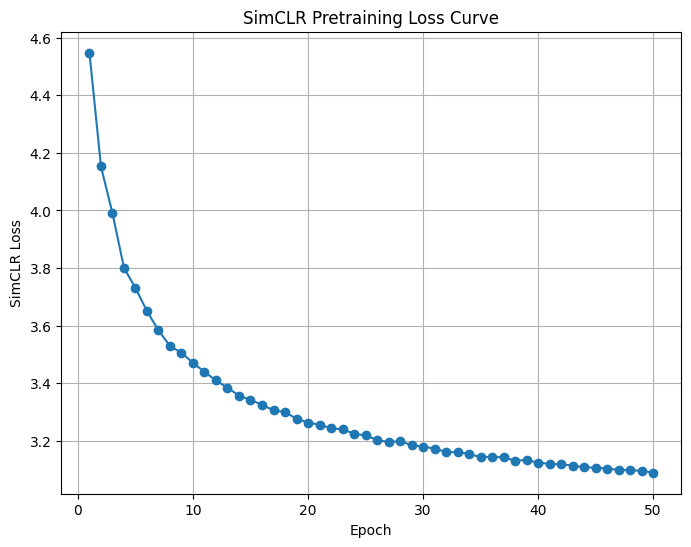

In [7]:
# plot simclr loss curve
plt.figure(figsize=(8,6))
plt.plot(range(1, len(simclr_losses)+1), simclr_losses, marker='o')
plt.xlabel("Epoch"); plt.ylabel("SimCLR Loss"); plt.title("SimCLR Pretraining Loss Curve")
plt.grid(True); plt.show()

In [ ]:
# Fine-tuning model using pretrained EfficientNet-B0 encoder

class FineTuneEfficientNet(nn.Module):
    def __init__(self, simclr_model, num_classes):
        super().__init__()
        #  Backbone: directly use SimCLR encoder weights 
        backbone = timm.create_model("efficientnet_b0", pretrained=False, num_classes=0, global_pool="avg")
        # load all pretrained SimCLR encoder weights
        backbone.load_state_dict(simclr_model.encoder.model.state_dict())
        print("Loaded entire SimCLR encoder weights into EfficientNet-B0 backbone.")
        self.backbone = backbone

        #  Classifier head 
        feat_dim = getattr(self.backbone, "num_features", simclr_model.encoder.out_dim)
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(feat_dim),
            nn.Linear(feat_dim, feat_dim // 2),
            nn.ReLU(inplace=True),
            nn.Linear(feat_dim // 2, num_classes)
        )

    def forward(self, x):
        # backbone returns pooled vector (B, feat_dim) when global_pool="avg"
        feat = self.backbone(x)
        logits = self.classifier(feat)
        return logits


num_classes = len(class_names)
finetune_model = FineTuneEfficientNet(simclr, num_classes).to(device)


Loaded entire SimCLR encoder weights into EfficientNet-B0 backbone.


In [ ]:
# Fine-tune training loop
optimizer_ft = torch.optim.AdamW([
    {'params': finetune_model.backbone.parameters(), 'lr': FINETUNE_LR/5},
    {'params': finetune_model.classifier.parameters(), 'lr': FINETUNE_LR}
], weight_decay=1e-4)

criterion_ft = nn.CrossEntropyLoss()
best_val_acc = 0.0

train_losses = []; train_accs = []
val_losses = []; val_accs = []

finetune_best_path = os.path.join(SAVE_DIR, "finetune_best_efficientnetb0.pth")

for epoch in range(1, FINETUNE_EPOCHS+1):
    # Train
    finetune_model.train()
    running_loss = 0.0; running_corrects = 0; total = 0
    pbar = tqdm(train_loader, desc=f"Finetune Train Epoch {epoch}/{FINETUNE_EPOCHS}")
    for imgs, labels in pbar:
        imgs = imgs.to(device); labels = labels.to(device)
        optimizer_ft.zero_grad()
        outputs = finetune_model(imgs)
        loss = criterion_ft(outputs, labels)
        loss.backward()
        optimizer_ft.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
        total += imgs.size(0)
        pbar.set_postfix(train_loss=running_loss/total, train_acc=running_corrects/total)

    epoch_train_loss = running_loss / total
    epoch_train_acc = running_corrects / total
    train_losses.append(epoch_train_loss); train_accs.append(epoch_train_acc)

    # Validation
    finetune_model.eval()
    running_loss = 0.0; running_corrects = 0; total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device); labels = labels.to(device)
            outputs = finetune_model(imgs)
            loss = criterion_ft(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()
            total += imgs.size(0)
    epoch_val_loss = running_loss / total
    epoch_val_acc = running_corrects / total
    val_losses.append(epoch_val_loss); val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch}/{FINETUNE_EPOCHS} | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    # Save best
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': finetune_model.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            'val_acc': best_val_acc
        }, finetune_best_path)
        print(f"  Saved best finetune model (val_acc={best_val_acc:.4f}) -> {finetune_best_path}")



Finetune Train Epoch 1/50: 100%|██████████| 268/268 [01:16<00:00,  3.49it/s, train_acc=0.458, train_loss=1.56]


Epoch 1/50 | Train Loss: 1.5560 | Train Acc: 0.4579 | Val Loss: 1.2821 | Val Acc: 0.5547
  Saved best finetune model (val_acc=0.5547) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 2/50: 100%|██████████| 268/268 [01:17<00:00,  3.45it/s, train_acc=0.565, train_loss=1.26]


Epoch 2/50 | Train Loss: 1.2613 | Train Acc: 0.5651 | Val Loss: 1.1282 | Val Acc: 0.6183
  Saved best finetune model (val_acc=0.6183) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 3/50: 100%|██████████| 268/268 [01:16<00:00,  3.48it/s, train_acc=0.602, train_loss=1.13]


Epoch 3/50 | Train Loss: 1.1290 | Train Acc: 0.6025 | Val Loss: 1.0009 | Val Acc: 0.6660
  Saved best finetune model (val_acc=0.6660) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 4/50: 100%|██████████| 268/268 [01:16<00:00,  3.49it/s, train_acc=0.63, train_loss=1.04] 


Epoch 4/50 | Train Loss: 1.0445 | Train Acc: 0.6301 | Val Loss: 0.9123 | Val Acc: 0.6904
  Saved best finetune model (val_acc=0.6904) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 5/50: 100%|██████████| 268/268 [01:19<00:00,  3.39it/s, train_acc=0.662, train_loss=0.971]


Epoch 5/50 | Train Loss: 0.9712 | Train Acc: 0.6615 | Val Loss: 0.8405 | Val Acc: 0.7297
  Saved best finetune model (val_acc=0.7297) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 6/50: 100%|██████████| 268/268 [01:17<00:00,  3.45it/s, train_acc=0.687, train_loss=0.905]


Epoch 6/50 | Train Loss: 0.9046 | Train Acc: 0.6870 | Val Loss: 0.7669 | Val Acc: 0.7577
  Saved best finetune model (val_acc=0.7577) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 7/50: 100%|██████████| 268/268 [01:17<00:00,  3.46it/s, train_acc=0.703, train_loss=0.841]


Epoch 7/50 | Train Loss: 0.8414 | Train Acc: 0.7034 | Val Loss: 0.7073 | Val Acc: 0.7746
  Saved best finetune model (val_acc=0.7746) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 8/50: 100%|██████████| 268/268 [01:16<00:00,  3.51it/s, train_acc=0.725, train_loss=0.789]


Epoch 8/50 | Train Loss: 0.7892 | Train Acc: 0.7247 | Val Loss: 0.6547 | Val Acc: 0.7783
  Saved best finetune model (val_acc=0.7783) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 9/50: 100%|██████████| 268/268 [01:17<00:00,  3.45it/s, train_acc=0.736, train_loss=0.751]


Epoch 9/50 | Train Loss: 0.7515 | Train Acc: 0.7362 | Val Loss: 0.5938 | Val Acc: 0.8054
  Saved best finetune model (val_acc=0.8054) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 10/50: 100%|██████████| 268/268 [01:17<00:00,  3.46it/s, train_acc=0.76, train_loss=0.698] 


Epoch 10/50 | Train Loss: 0.6977 | Train Acc: 0.7600 | Val Loss: 0.5584 | Val Acc: 0.8138
  Saved best finetune model (val_acc=0.8138) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 11/50: 100%|██████████| 268/268 [01:17<00:00,  3.44it/s, train_acc=0.765, train_loss=0.67] 


Epoch 11/50 | Train Loss: 0.6696 | Train Acc: 0.7649 | Val Loss: 0.5067 | Val Acc: 0.8372
  Saved best finetune model (val_acc=0.8372) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 12/50: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s, train_acc=0.783, train_loss=0.627]


Epoch 12/50 | Train Loss: 0.6267 | Train Acc: 0.7829 | Val Loss: 0.4597 | Val Acc: 0.8559
  Saved best finetune model (val_acc=0.8559) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 13/50: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s, train_acc=0.798, train_loss=0.586]


Epoch 13/50 | Train Loss: 0.5858 | Train Acc: 0.7983 | Val Loss: 0.4484 | Val Acc: 0.8550


Finetune Train Epoch 14/50: 100%|██████████| 268/268 [01:17<00:00,  3.48it/s, train_acc=0.806, train_loss=0.562]


Epoch 14/50 | Train Loss: 0.5615 | Train Acc: 0.8056 | Val Loss: 0.3969 | Val Acc: 0.8700
  Saved best finetune model (val_acc=0.8700) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 15/50: 100%|██████████| 268/268 [01:16<00:00,  3.50it/s, train_acc=0.808, train_loss=0.538]


Epoch 15/50 | Train Loss: 0.5385 | Train Acc: 0.8081 | Val Loss: 0.3742 | Val Acc: 0.8775
  Saved best finetune model (val_acc=0.8775) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 16/50: 100%|██████████| 268/268 [01:17<00:00,  3.44it/s, train_acc=0.83, train_loss=0.493] 


Epoch 16/50 | Train Loss: 0.4935 | Train Acc: 0.8304 | Val Loss: 0.3393 | Val Acc: 0.8999
  Saved best finetune model (val_acc=0.8999) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 17/50: 100%|██████████| 268/268 [01:16<00:00,  3.48it/s, train_acc=0.839, train_loss=0.474]


Epoch 17/50 | Train Loss: 0.4741 | Train Acc: 0.8394 | Val Loss: 0.3162 | Val Acc: 0.8980


Finetune Train Epoch 18/50: 100%|██████████| 268/268 [01:18<00:00,  3.43it/s, train_acc=0.843, train_loss=0.462]


Epoch 18/50 | Train Loss: 0.4621 | Train Acc: 0.8427 | Val Loss: 0.2867 | Val Acc: 0.9102
  Saved best finetune model (val_acc=0.9102) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 19/50: 100%|██████████| 268/268 [01:16<00:00,  3.50it/s, train_acc=0.856, train_loss=0.423]


Epoch 19/50 | Train Loss: 0.4227 | Train Acc: 0.8558 | Val Loss: 0.2699 | Val Acc: 0.9205
  Saved best finetune model (val_acc=0.9205) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 20/50: 100%|██████████| 268/268 [01:17<00:00,  3.44it/s, train_acc=0.863, train_loss=0.399]


Epoch 20/50 | Train Loss: 0.3989 | Train Acc: 0.8627 | Val Loss: 0.2487 | Val Acc: 0.9270
  Saved best finetune model (val_acc=0.9270) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 21/50: 100%|██████████| 268/268 [01:17<00:00,  3.48it/s, train_acc=0.871, train_loss=0.382]


Epoch 21/50 | Train Loss: 0.3823 | Train Acc: 0.8710 | Val Loss: 0.2304 | Val Acc: 0.9242


Finetune Train Epoch 22/50: 100%|██████████| 268/268 [01:16<00:00,  3.52it/s, train_acc=0.883, train_loss=0.355]


Epoch 22/50 | Train Loss: 0.3546 | Train Acc: 0.8832 | Val Loss: 0.2076 | Val Acc: 0.9383
  Saved best finetune model (val_acc=0.9383) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 23/50: 100%|██████████| 268/268 [01:17<00:00,  3.47it/s, train_acc=0.882, train_loss=0.346]


Epoch 23/50 | Train Loss: 0.3456 | Train Acc: 0.8823 | Val Loss: 0.2013 | Val Acc: 0.9420
  Saved best finetune model (val_acc=0.9420) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 24/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s, train_acc=0.897, train_loss=0.315]


Epoch 24/50 | Train Loss: 0.3154 | Train Acc: 0.8969 | Val Loss: 0.1808 | Val Acc: 0.9486
  Saved best finetune model (val_acc=0.9486) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 25/50: 100%|██████████| 268/268 [01:17<00:00,  3.45it/s, train_acc=0.901, train_loss=0.301]


Epoch 25/50 | Train Loss: 0.3006 | Train Acc: 0.9013 | Val Loss: 0.1619 | Val Acc: 0.9542
  Saved best finetune model (val_acc=0.9542) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 26/50: 100%|██████████| 268/268 [01:17<00:00,  3.48it/s, train_acc=0.907, train_loss=0.285]


Epoch 26/50 | Train Loss: 0.2848 | Train Acc: 0.9066 | Val Loss: 0.1583 | Val Acc: 0.9598
  Saved best finetune model (val_acc=0.9598) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 27/50: 100%|██████████| 268/268 [01:17<00:00,  3.47it/s, train_acc=0.91, train_loss=0.276] 


Epoch 27/50 | Train Loss: 0.2760 | Train Acc: 0.9100 | Val Loss: 0.1476 | Val Acc: 0.9560


Finetune Train Epoch 28/50: 100%|██████████| 268/268 [01:17<00:00,  3.44it/s, train_acc=0.906, train_loss=0.273]


Epoch 28/50 | Train Loss: 0.2728 | Train Acc: 0.9063 | Val Loss: 0.1423 | Val Acc: 0.9570


Finetune Train Epoch 29/50: 100%|██████████| 268/268 [01:16<00:00,  3.48it/s, train_acc=0.914, train_loss=0.255]


Epoch 29/50 | Train Loss: 0.2551 | Train Acc: 0.9144 | Val Loss: 0.1259 | Val Acc: 0.9663
  Saved best finetune model (val_acc=0.9663) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 30/50: 100%|██████████| 268/268 [01:17<00:00,  3.45it/s, train_acc=0.926, train_loss=0.229]


Epoch 30/50 | Train Loss: 0.2289 | Train Acc: 0.9262 | Val Loss: 0.1115 | Val Acc: 0.9729
  Saved best finetune model (val_acc=0.9729) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 31/50: 100%|██████████| 268/268 [01:17<00:00,  3.48it/s, train_acc=0.929, train_loss=0.217]


Epoch 31/50 | Train Loss: 0.2173 | Train Acc: 0.9293 | Val Loss: 0.1096 | Val Acc: 0.9691


Finetune Train Epoch 32/50: 100%|██████████| 268/268 [01:17<00:00,  3.47it/s, train_acc=0.933, train_loss=0.212]


Epoch 32/50 | Train Loss: 0.2117 | Train Acc: 0.9325 | Val Loss: 0.0970 | Val Acc: 0.9747
  Saved best finetune model (val_acc=0.9747) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 33/50: 100%|██████████| 268/268 [01:17<00:00,  3.48it/s, train_acc=0.931, train_loss=0.205]


Epoch 33/50 | Train Loss: 0.2049 | Train Acc: 0.9313 | Val Loss: 0.0944 | Val Acc: 0.9804
  Saved best finetune model (val_acc=0.9804) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 34/50: 100%|██████████| 268/268 [01:19<00:00,  3.39it/s, train_acc=0.939, train_loss=0.186]


Epoch 34/50 | Train Loss: 0.1859 | Train Acc: 0.9386 | Val Loss: 0.0811 | Val Acc: 0.9822
  Saved best finetune model (val_acc=0.9822) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 35/50: 100%|██████████| 268/268 [01:17<00:00,  3.44it/s, train_acc=0.941, train_loss=0.183]


Epoch 35/50 | Train Loss: 0.1834 | Train Acc: 0.9406 | Val Loss: 0.0761 | Val Acc: 0.9757


Finetune Train Epoch 36/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s, train_acc=0.941, train_loss=0.183]


Epoch 36/50 | Train Loss: 0.1830 | Train Acc: 0.9406 | Val Loss: 0.0683 | Val Acc: 0.9822


Finetune Train Epoch 37/50: 100%|██████████| 268/268 [01:17<00:00,  3.48it/s, train_acc=0.951, train_loss=0.164]


Epoch 37/50 | Train Loss: 0.1639 | Train Acc: 0.9507 | Val Loss: 0.0613 | Val Acc: 0.9850
  Saved best finetune model (val_acc=0.9850) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 38/50: 100%|██████████| 268/268 [01:19<00:00,  3.39it/s, train_acc=0.952, train_loss=0.155]


Epoch 38/50 | Train Loss: 0.1554 | Train Acc: 0.9521 | Val Loss: 0.0660 | Val Acc: 0.9860
  Saved best finetune model (val_acc=0.9860) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 39/50: 100%|██████████| 268/268 [01:17<00:00,  3.46it/s, train_acc=0.951, train_loss=0.154]


Epoch 39/50 | Train Loss: 0.1536 | Train Acc: 0.9507 | Val Loss: 0.0499 | Val Acc: 0.9878
  Saved best finetune model (val_acc=0.9878) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 40/50: 100%|██████████| 268/268 [01:17<00:00,  3.47it/s, train_acc=0.953, train_loss=0.149]


Epoch 40/50 | Train Loss: 0.1490 | Train Acc: 0.9531 | Val Loss: 0.0521 | Val Acc: 0.9860


Finetune Train Epoch 41/50: 100%|██████████| 268/268 [01:17<00:00,  3.45it/s, train_acc=0.959, train_loss=0.131]


Epoch 41/50 | Train Loss: 0.1311 | Train Acc: 0.9590 | Val Loss: 0.0453 | Val Acc: 0.9878


Finetune Train Epoch 42/50: 100%|██████████| 268/268 [01:17<00:00,  3.45it/s, train_acc=0.96, train_loss=0.133] 


Epoch 42/50 | Train Loss: 0.1327 | Train Acc: 0.9597 | Val Loss: 0.0495 | Val Acc: 0.9925
  Saved best finetune model (val_acc=0.9925) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 43/50: 100%|██████████| 268/268 [01:17<00:00,  3.44it/s, train_acc=0.966, train_loss=0.117]


Epoch 43/50 | Train Loss: 0.1174 | Train Acc: 0.9655 | Val Loss: 0.0363 | Val Acc: 0.9916


Finetune Train Epoch 44/50: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s, train_acc=0.966, train_loss=0.112]


Epoch 44/50 | Train Loss: 0.1122 | Train Acc: 0.9662 | Val Loss: 0.0352 | Val Acc: 0.9935
  Saved best finetune model (val_acc=0.9935) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 45/50: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s, train_acc=0.963, train_loss=0.117]


Epoch 45/50 | Train Loss: 0.1171 | Train Acc: 0.9627 | Val Loss: 0.0310 | Val Acc: 0.9935


Finetune Train Epoch 46/50: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s, train_acc=0.966, train_loss=0.109]


Epoch 46/50 | Train Loss: 0.1095 | Train Acc: 0.9662 | Val Loss: 0.0292 | Val Acc: 0.9963
  Saved best finetune model (val_acc=0.9963) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


Finetune Train Epoch 47/50: 100%|██████████| 268/268 [01:16<00:00,  3.51it/s, train_acc=0.973, train_loss=0.097] 


Epoch 47/50 | Train Loss: 0.0970 | Train Acc: 0.9726 | Val Loss: 0.0259 | Val Acc: 0.9935


Finetune Train Epoch 48/50: 100%|██████████| 268/268 [01:17<00:00,  3.44it/s, train_acc=0.97, train_loss=0.102]  


Epoch 48/50 | Train Loss: 0.1015 | Train Acc: 0.9698 | Val Loss: 0.0250 | Val Acc: 0.9953


Finetune Train Epoch 49/50: 100%|██████████| 268/268 [01:17<00:00,  3.48it/s, train_acc=0.971, train_loss=0.0902]


Epoch 49/50 | Train Loss: 0.0902 | Train Acc: 0.9707 | Val Loss: 0.0200 | Val Acc: 0.9963


Finetune Train Epoch 50/50: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s, train_acc=0.973, train_loss=0.09]  


Epoch 50/50 | Train Loss: 0.0900 | Train Acc: 0.9728 | Val Loss: 0.0173 | Val Acc: 0.9981
  Saved best finetune model (val_acc=0.9981) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_EfficientnetB0/outputs_simclr_ssl\finetune_best_efficientnetb0.pth


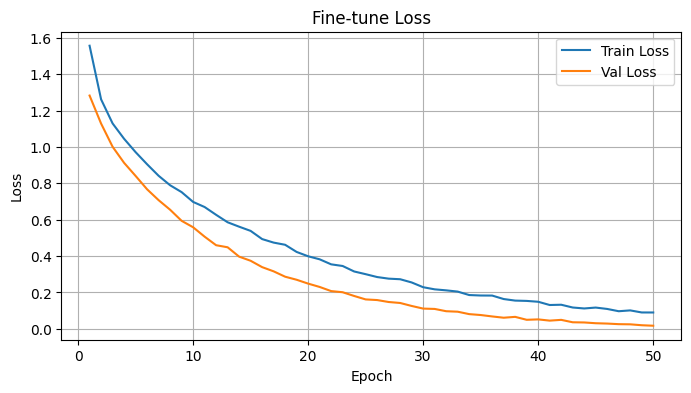

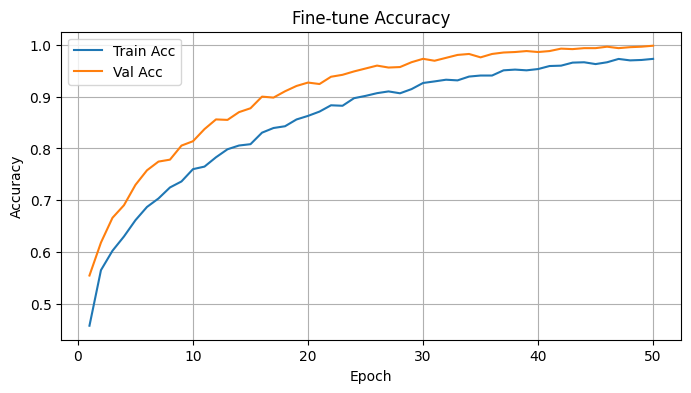

In [10]:

# plot fine-tune curves
plt.figure(figsize=(8,4))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Fine-tune Loss"); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Acc')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Val Acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Fine-tune Accuracy"); plt.legend(); plt.grid(True)
plt.show()

Evaluating on test set: 100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Test metrics:
  Accuracy:  0.9981
  Precision (macro): 0.9986
  Recall (macro):    0.9979
  F1 (macro):        0.9983

Classification report (per-class):
                                                precision    recall  f1-score   support

                                   1Gallstones       1.00      1.00      1.00       133
                  2Abdomen and retroperitoneum       1.00      1.00      1.00       117
                                3cholecystitis       1.00      0.99      1.00       114
      4Membranous and gangrenous cholecystitis       1.00      1.00      1.00       123
                                  5Perforation       1.00      1.00      1.00       106
              6Polyps and cholesterol crystals       1.00      0.99      1.00       102
                              7Adenomyomatosis       1.00      1.00      1.00       117
                                    8Carcinoma       0.99      1.00      0.99       159
9Various causes of gallbladder wall thickening       

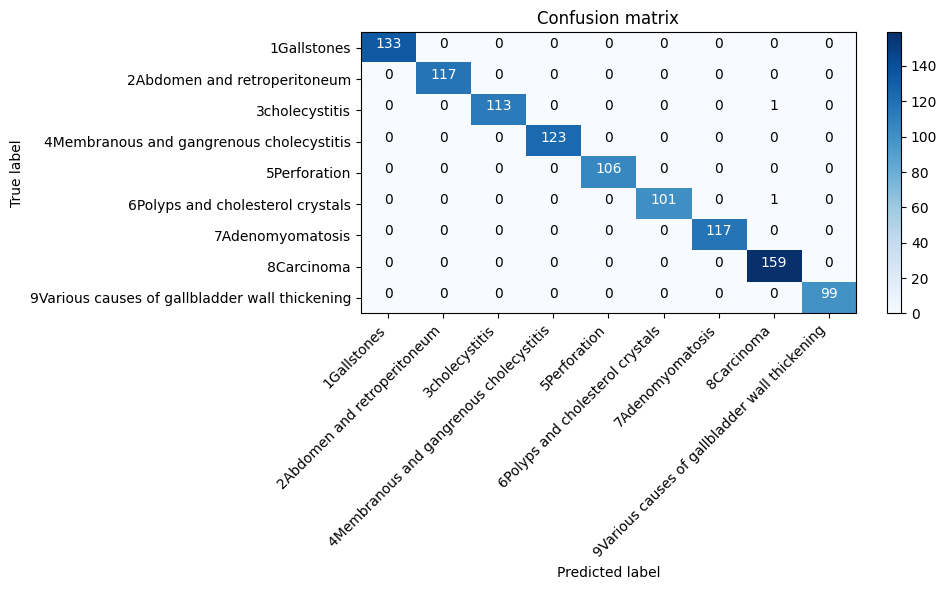

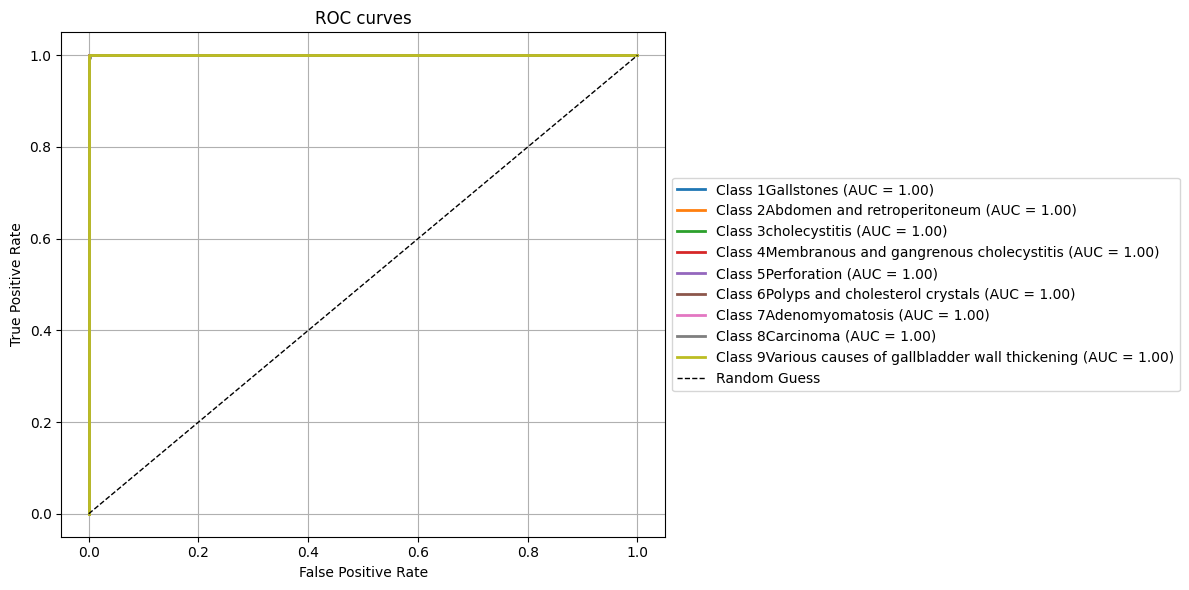

In [ ]:
# Evaluation on test set (load best weights)
checkpoint = torch.load(finetune_best_path, map_location=device)
finetune_model.load_state_dict(checkpoint['model_state_dict'])
finetune_model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating on test set"):
        imgs = imgs.to(device)
        outputs = finetune_model(imgs)  # B, num_classes
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Overall metrics
acc = accuracy_score(all_labels, all_preds)
precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
print("Test metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision (macro): {precision_macro:.4f}")
print(f"  Recall (macro):    {recall_macro:.4f}")
print(f"  F1 (macro):        {f1_macro:.4f}\n")

# Per-class report
print("Classification report (per-class):")
print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot confusion matrix
plt.figure(figsize=(10,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, aspect = 'auto')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.show()

# ROC curves (One-vs-Rest)
# Binarize labels
y_test_bin = label_binarize(all_labels, classes=range(num_classes))
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(12,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--', lw=1, label = 'Random Guess')
plt.title("ROC curves")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.grid(True)

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

Evaluating on test set: 100%|██████████| 34/34 [00:10<00:00,  3.29it/s]


Test metrics:
  Accuracy:  0.9981
  Precision (weighted): 0.9982
  Recall (weighted):    0.9981
  F1 (weighted):        0.9981

Classification report (per-class):
                                                precision    recall  f1-score   support

                                   1Gallstones       1.00      1.00      1.00       133
                  2Abdomen and retroperitoneum       1.00      1.00      1.00       117
                                3cholecystitis       1.00      0.99      1.00       114
      4Membranous and gangrenous cholecystitis       1.00      1.00      1.00       123
                                  5Perforation       1.00      1.00      1.00       106
              6Polyps and cholesterol crystals       1.00      0.99      1.00       102
                              7Adenomyomatosis       1.00      1.00      1.00       117
                                    8Carcinoma       0.99      1.00      0.99       159
9Various causes of gallbladder wall thickeni

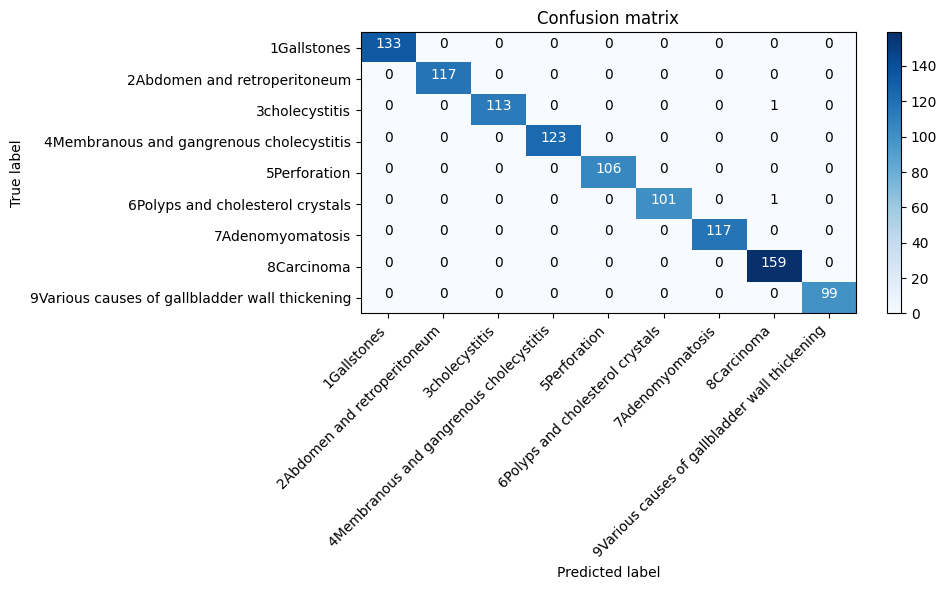

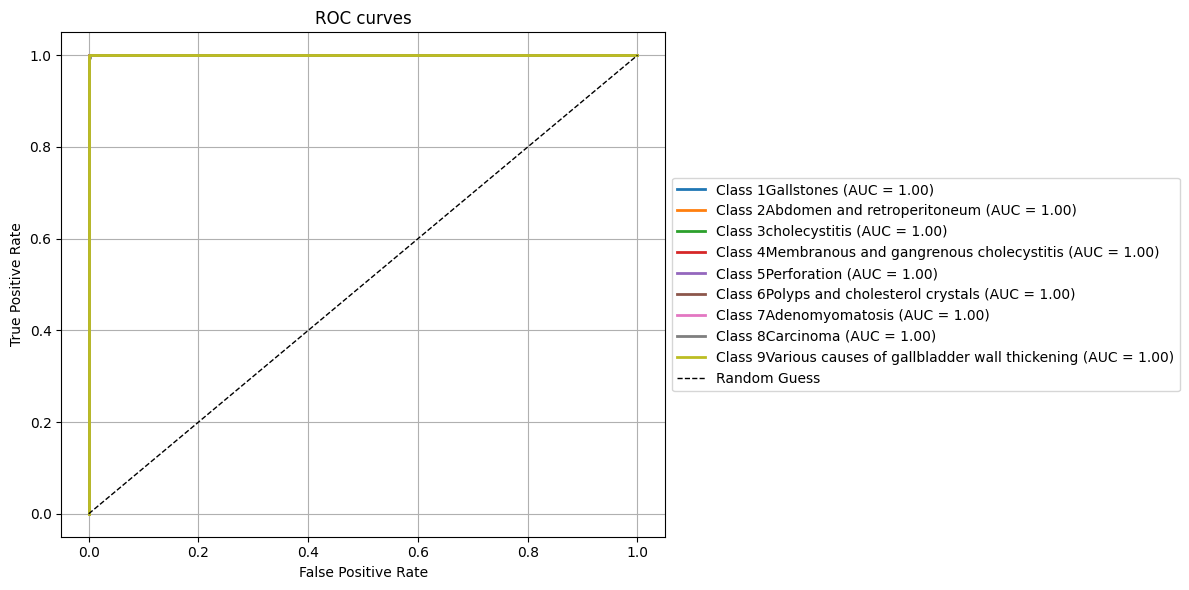

In [ ]:
# Evaluation on test set (load best weights)
checkpoint = torch.load(finetune_best_path, map_location=device)
finetune_model.load_state_dict(checkpoint['model_state_dict'])
finetune_model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating on test set"):
        imgs = imgs.to(device)
        outputs = finetune_model(imgs)  # B, num_classes
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Overall metrics
acc = accuracy_score(all_labels, all_preds)
precision_macro = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall_macro = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1_macro = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
print("Test metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision (weighted): {precision_macro:.4f}")
print(f"  Recall (weighted):    {recall_macro:.4f}")
print(f"  F1 (weighted):        {f1_macro:.4f}\n")

# Per-class report
print("Classification report (per-class):")
print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot confusion matrix
plt.figure(figsize=(10,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, aspect = 'auto')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.show()

# ROC curves (One-vs-Rest)
# Binarize labels
y_test_bin = label_binarize(all_labels, classes=range(num_classes))
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# micro-average
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

plt.figure(figsize=(12,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--', lw=1, label = 'Random Guess')
plt.title("ROC curves")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.grid(True)

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# all_labels and all_preds are numpy arrays from  test set
per_class_metrics = {}

for i, cls_name in enumerate(classes):
    # mask for this class
    idx = all_labels == i
    y_true_cls = all_labels[idx]
    y_pred_cls = all_preds[idx]
    
    # compute metrics
    acc = accuracy_score(y_true_cls, y_pred_cls)  
    prec = precision_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    rec = recall_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    
    per_class_metrics[cls_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }

# Print nicely
for cls_name, metrics in per_class_metrics.items():
    print(f"Class: {cls_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()


Class: 1Gallstones
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 2Abdomen and retroperitoneum
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 3cholecystitis
  accuracy: 0.9912
  precision: 1.0000
  recall: 0.9912
  f1_score: 0.9956

Class: 4Membranous and gangrenous cholecystitis
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 5Perforation
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 6Polyps and cholesterol crystals
  accuracy: 0.9902
  precision: 1.0000
  recall: 0.9902
  f1_score: 0.9951

Class: 7Adenomyomatosis
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 8Carcinoma
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 9Various causes of gallbladder wall thickening
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# all_labels and all_preds are numpy arrays from  test set
per_class_metrics = {}

for i, cls_name in enumerate(classes):
    # mask for this class
    idx = all_labels == i
    y_true_cls = all_labels[idx]
    y_pred_cls = all_preds[idx]
    
    # compute metrics
    acc = accuracy_score(y_true_cls, y_pred_cls)  
    prec = precision_score(y_true_cls, y_pred_cls, labels=[i], average='weighted', zero_division=0)
    rec = recall_score(y_true_cls, y_pred_cls, labels=[i], average='weighted', zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, labels=[i], average='weighted', zero_division=0)
    
    per_class_metrics[cls_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }

# Print nicely
for cls_name, metrics in per_class_metrics.items():
    print(f"Class: {cls_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()


Class: 1Gallstones
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 2Abdomen and retroperitoneum
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 3cholecystitis
  accuracy: 0.9912
  precision: 1.0000
  recall: 0.9912
  f1_score: 0.9956

Class: 4Membranous and gangrenous cholecystitis
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 5Perforation
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 6Polyps and cholesterol crystals
  accuracy: 0.9902
  precision: 1.0000
  recall: 0.9902
  f1_score: 0.9951

Class: 7Adenomyomatosis
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 8Carcinoma
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 9Various causes of gallbladder wall thickening
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

